# Importing the Libraries

In [36]:
import librosa
import numpy as np
import os
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input

# Extracting the features using MFCC from the audio samples

In [23]:
def extract_features(file_path, max_pad_len=174):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        if mfcc.shape[1] < max_pad_len:
            # Pad the mfcc with 0s
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate the mfcc
            mfcc = mfcc[:, :max_pad_len]
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


# Loading the database

In [24]:
def load_data(base_dir, protocol_path):
    data = pd.read_csv(protocol_path, sep=' ', header=None, names=['speaker_id','filename','system_id','null','class_name'])
    features, labels = [], []
    for index, row in data.iterrows():
        file_path = os.path.join(base_dir, row['filename'] + '.flac')
        # print(file_path)
        mfcc = extract_features(file_path)
        features.append(mfcc)
        labels.append(1 if row['class_name'] == 'bonafide' else 0)
    features = np.array(features)
    labels = np.array(labels)
    return features, labels

# Creating a model

In [25]:
def build_lstm_model(input_shape):
    model = Sequential([
        Input(input_shape),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Setting the protocol path and spliting the data into test and train datasets

In [26]:
base_dir = './input/asvspoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac'
protocol_path = './input/asvspoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'

X, y = load_data(base_dir, protocol_path)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Training the model

In [28]:
input_shape = (X_train.shape[1], X_train.shape[2])  # MFCCs shape
model = build_lstm_model(input_shape)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8914 - loss: 0.2931 - val_accuracy: 0.9399 - val_loss: 0.1462
Epoch 2/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9504 - loss: 0.1305 - val_accuracy: 0.9498 - val_loss: 0.1288
Epoch 3/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9567 - loss: 0.1091 - val_accuracy: 0.9509 - val_loss: 0.1205
Epoch 4/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9681 - loss: 0.0883 - val_accuracy: 0.9602 - val_loss: 0.0994
Epoch 5/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9764 - loss: 0.0682 - val_accuracy: 0.9673 - val_loss: 0.0860
Epoch 6/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9788 - loss: 0.0624 - val_accuracy: 0.9701 - val_loss: 0.0811
Epoch 7/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9831 - loss: 0.0532 - val_accuracy: 0.9744 - val_loss: 0.0771
Epoch 8/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9849 - loss: 0.0457 - 

In [41]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 40, 64)         │        61,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 40, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295,813 (1.13 MB)

 Trainable params: 98,561 (385.00 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 197,124 (770.02 KB)

# Creating graphs for Model Accuracy and Model Loss

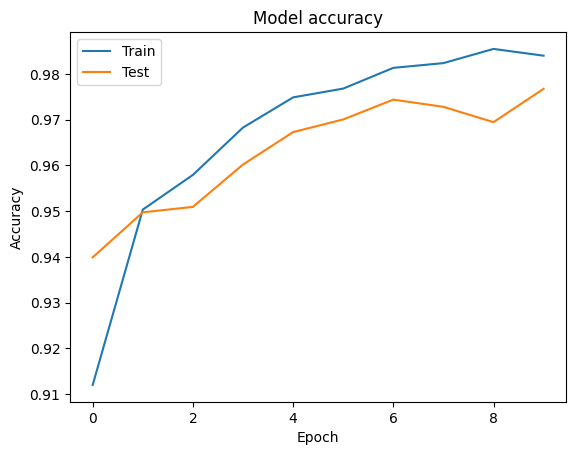

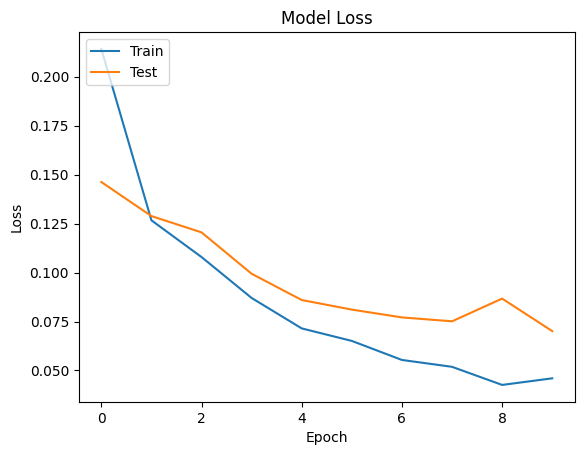

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Ploting the graphs for Weights and Biases for each layer

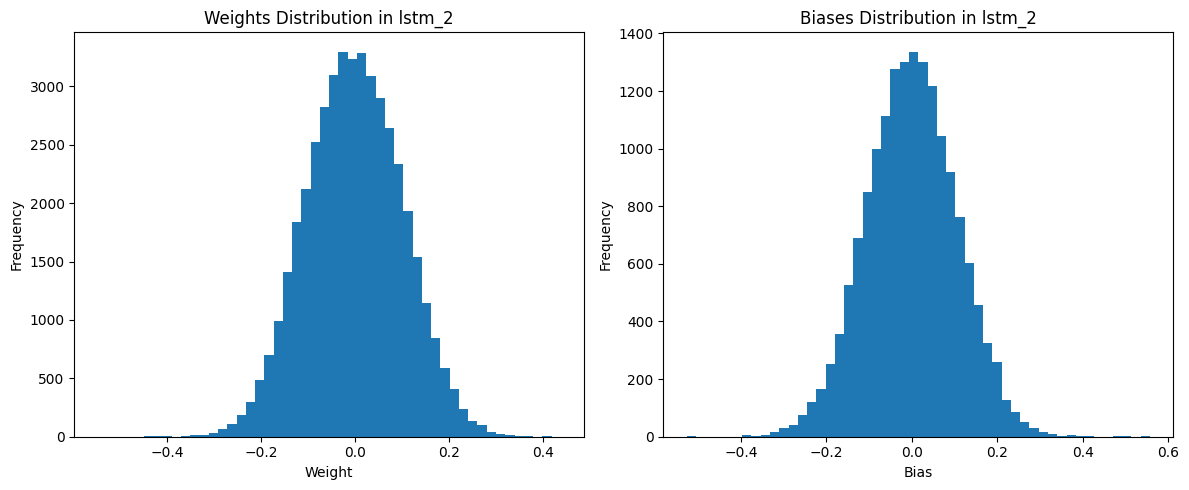

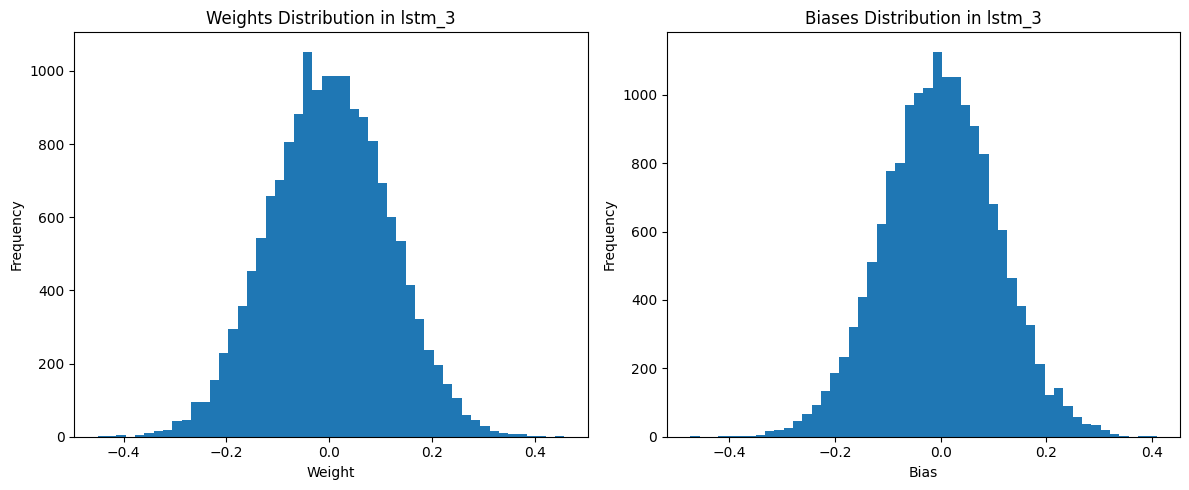

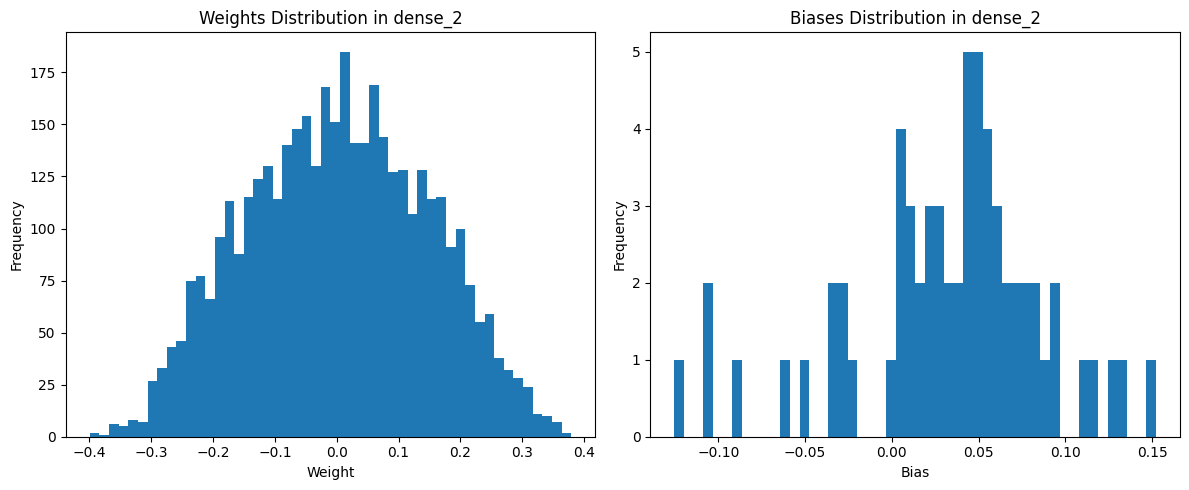

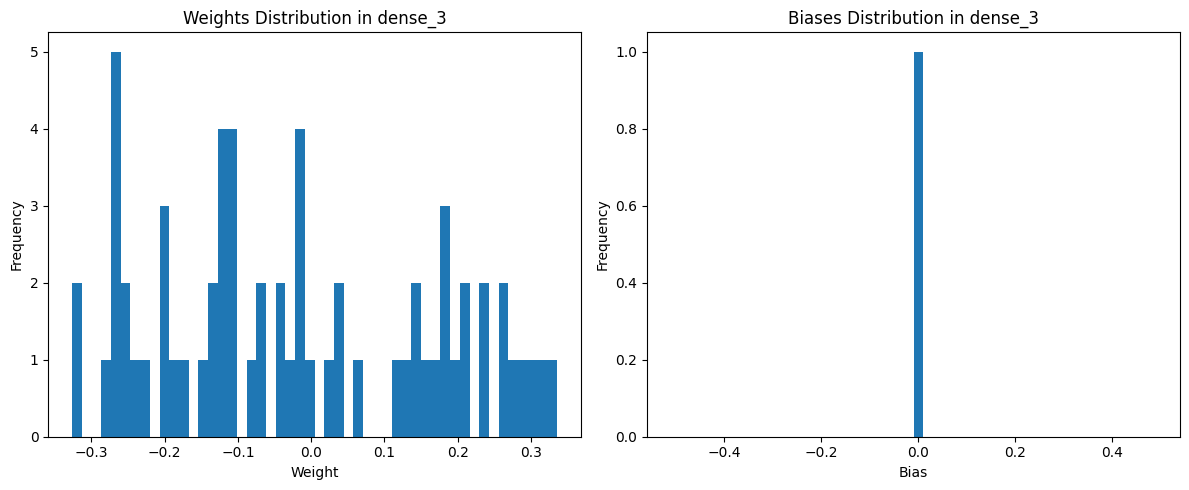

In [35]:
def plot_layer_weights(layer_name, model):
    weights = model.get_layer(layer_name).get_weights()[0]  # Get the weights
    biases = model.get_layer(layer_name).get_weights()[1]  # Get the biases
    
    plt.figure(figsize=(12, 5))

    # Plotting the weights
    plt.subplot(1, 2, 1)
    plt.hist(weights.flatten(), bins=50)
    plt.title(f'Weights Distribution in {layer_name}')
    plt.xlabel('Weight')
    plt.ylabel('Frequency')

    # Plotting the biases
    plt.subplot(1, 2, 2)
    plt.hist(biases.flatten(), bins=50)
    plt.title(f'Biases Distribution in {layer_name}')
    plt.xlabel('Bias')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

for layer in model.layers:
    if type(layer) is LSTM or type(layer) is Dense:
        plot_layer_weights(layer.name, model)

### Generating a Confusion Matrix

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


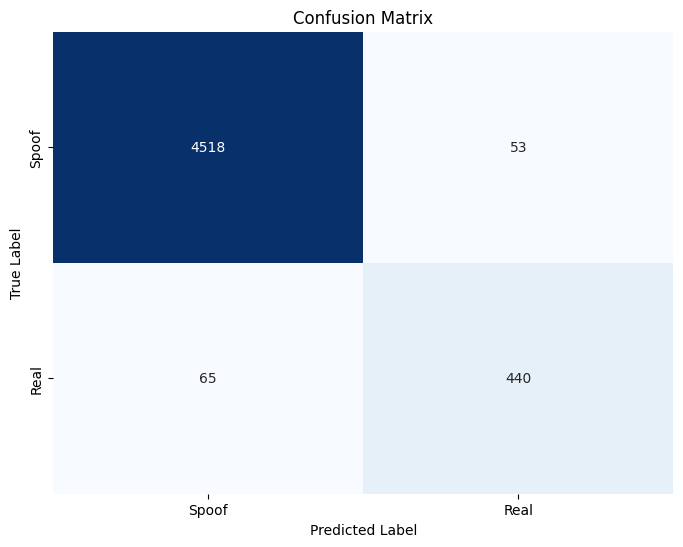

In [ ]:
predictions = model.predict(X_val)
y_pred = (predictions > 0.5).astype(int)
cm =confusion_matrix(y_val, y_pred)
# print(classification_report(y_val, y_pred))
class_names = ['Spoof', 'Real']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Performance Metrics Parameters

In [39]:
accuracy = accuracy_score(y_val, y_pred)*100
recall = recall_score(y_val, y_pred)*100  # Assumes the positive class is 1
precision = precision_score(y_val, y_pred)*100  # Assumes the positive class is 1
f1_score = f1_score(y_val, y_pred)*100  # Harmonic mean of precision and recall

# Print metrics
print(f"Accuracy: {accuracy:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"F1 Score: {f1_score:.2f}%")


Accuracy: 97.68%
Recall: 87.13%
Precision: 89.25%
F1 Score: 88.18%
